In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [3]:
BATCH_SIZE = 32
IMAGE_SIZE = 224
CHANNELS=3
EPOCHS=5

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "binary1",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 6981 files belonging to 2 classes.


In [5]:
class_names = dataset.class_names
class_names

['D00', 'D40']

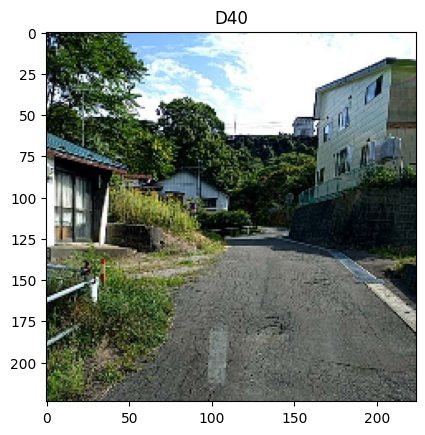

In [7]:
for image_batch, label_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.title(class_names[label_batch[0]])
    plt.axis("on")

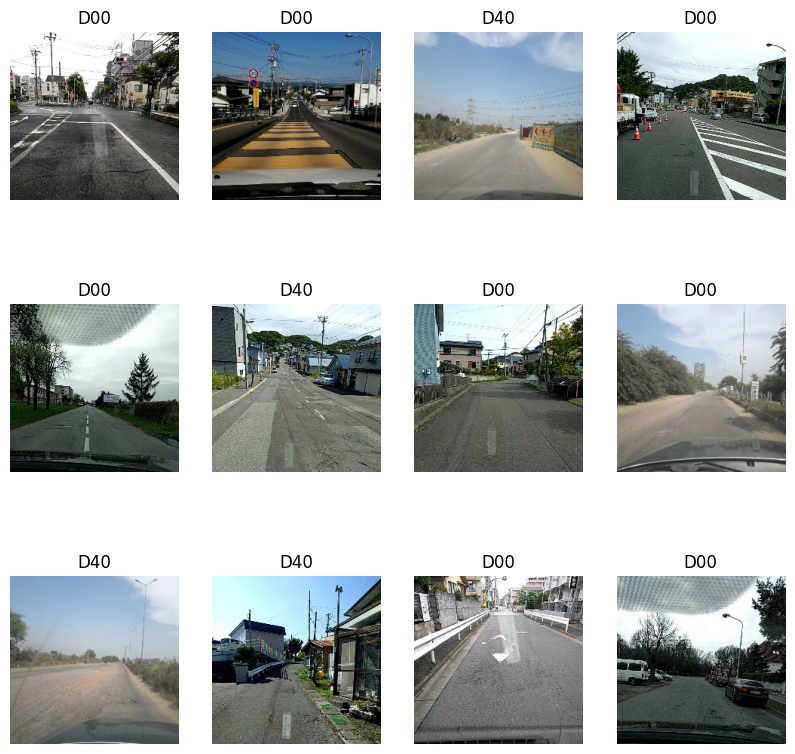

In [8]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [9]:
len(dataset)

219

In [10]:
train_size = 0.8
len(dataset)*train_size

175.20000000000002

In [13]:
train_ds = dataset.take(175)
len(train_ds)

175

In [14]:
test_ds = dataset.skip(175)
len(test_ds)

44

In [15]:
val_size=0.1
len(dataset)*val_size

21.900000000000002

In [16]:
val_ds = test_ds.take(22)
len(val_ds)

22

In [17]:
test_ds = test_ds.skip(22)
len(test_ds)

22

In [18]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [19]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [20]:
len(train_ds)

175

In [21]:
len(val_ds)

21

In [22]:
len(test_ds)

23

In [23]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [24]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [25]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [26]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)


In [27]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 2

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [28]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 224, 224, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 222, 222, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 111, 111, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 109, 109, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 54, 54, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 52, 52, 32)         

In [29]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [31]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
175/175 [==============================] - 68s 362ms/step - loss: 0.6680 - accuracy: 0.5977 - val_loss: 0.6610 - val_accuracy: 0.6027
Epoch 2/50
175/175 [==============================] - 58s 329ms/step - loss: 0.6492 - accuracy: 0.6154 - val_loss: 0.6341 - val_accuracy: 0.6488
Epoch 3/50
175/175 [==============================] - 61s 351ms/step - loss: 0.6355 - accuracy: 0.6530 - val_loss: 0.6512 - val_accuracy: 0.6533
Epoch 4/50
175/175 [==============================] - 62s 355ms/step - loss: 0.6378 - accuracy: 0.6511 - val_loss: 0.6202 - val_accuracy: 0.6652
Epoch 5/50
175/175 [==============================] - 58s 332ms/step - loss: 0.6322 - accuracy: 0.6541 - val_loss: 0.6200 - val_accuracy: 0.6533
Epoch 6/50
175/175 [==============================] - 60s 343ms/step - loss: 0.6308 - accuracy: 0.6491 - val_loss: 0.6262 - val_accuracy: 0.6592
Epoch 7/50
175/175 [==============================] - 60s 343ms/step - loss: 0.6265 - accuracy: 0.6579 - val_loss: 0.6349 - val_ac

In [32]:
scores = model.evaluate(test_ds)

23/23 [==============================] - 3s 109ms/step - loss: 0.5799 - accuracy: 0.6939


In [33]:
scores

[0.579868733882904, 0.6939350962638855]

In [34]:
history

In [35]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 175}

In [36]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [37]:
type(history.history['loss'])

list

In [38]:
len(history.history['loss'])

50

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy')

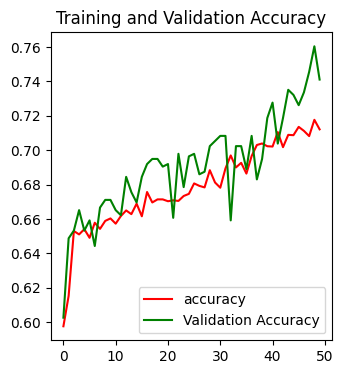

In [40]:
Epoch = len(acc)
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(range(Epoch), acc,color='red', label='accuracy')
plt.plot(range(Epoch), val_acc,color='green', label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


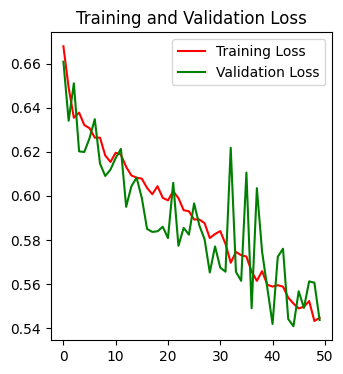

In [41]:
EPOCHS=len(loss)
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss,color='red', label='Training Loss')
plt.plot(range(EPOCHS), val_loss,color='green', label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: D00
1/1 [==============================] - 0s 273ms/step
predicted label: D00


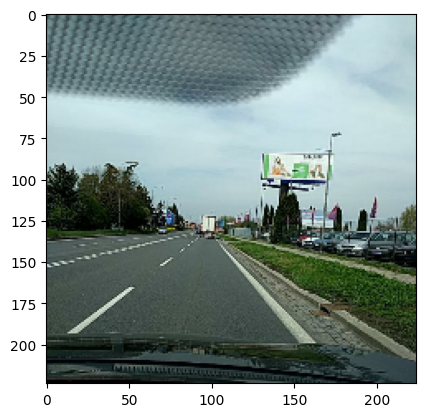

In [42]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [43]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 19ms/step


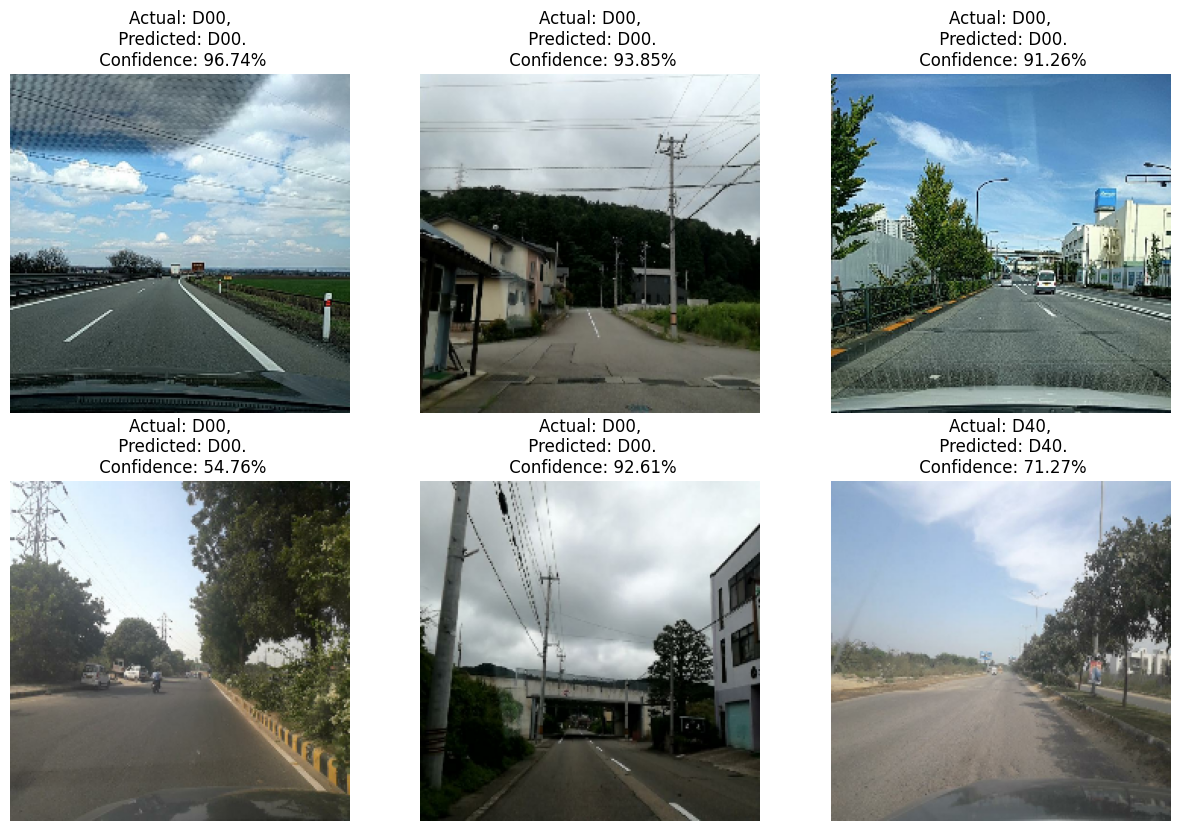

In [44]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(6):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

1/1 [==============================] - 0s 98ms/step


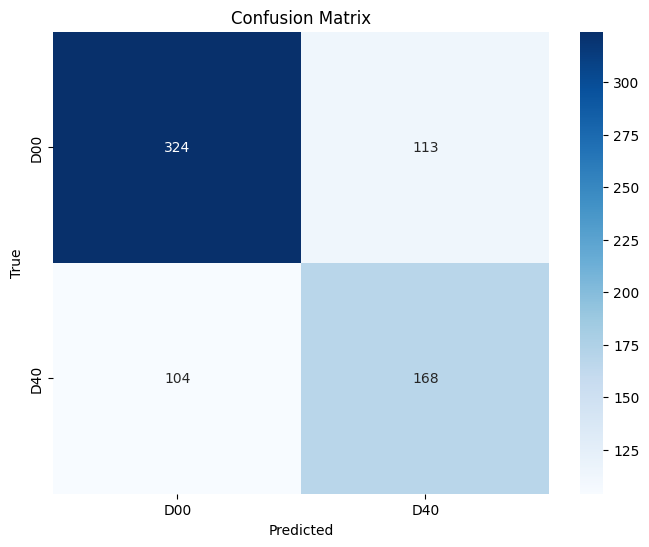

In [45]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Create lists to store ground truth and predicted labels
true_labels = []
predicted_labels = []

# Iterate through the test dataset
for images, labels in test_ds:
    true_labels.extend(labels.numpy())  # Ground truth labels
    predictions = model.predict(images)  # Predict labels
    predicted_labels.extend(np.argmax(predictions, axis=1))  # Predicted labels

# Calculate the confusion matrix
confusion_mtx = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [46]:
from sklearn.metrics import f1_score
f1 = f1_score(true_labels, predicted_labels, average='weighted')
print("F1 Score:", f1)

F1 Score: 0.694833457053182


In [47]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(true_labels, predicted_labels)
print("Accuracy:", accuracy)

Accuracy: 0.693935119887165


In [49]:
model.save("main_mode.h5")

In [61]:
import os
import keras
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
from keras.preprocessing import image
import numpy as np
from keras.models import load_model


def return_class(img_path):
    model=load_model('main_model.h5')
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    predictions = model.predict(img_array)
    return predictions

def return_class_name(predictions):
    class_name=np.argmax(predictions)
    print(class_name) 
    if class_name==0:
        return 'D00'
    else:
        return 'D40' 

value=return_class('binary1/D40/Czech_003537.jpg')
print(value)
for i in value:
    for j in i:
        print(j)
print(return_class_name(return_class('binary1/D40/Czech_003537.jpg')))

1/1 [==============================] - 0s 79ms/step
[[0.9373568  0.06264311]]
0.9373568
0.06264311
1/1 [==============================] - 0s 75ms/step
0
D00
